This page was created from a Jupyter notebook. The original notebook can be found [here](https://github.com/klane/databall/blob/master/notebooks/parameter-tuning.ipynb). It investigates tuning model parameters to achieve better performance. First we must import the necessary installed modules.

In [11]:
import itertools
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

We can then load in the datasets saved during [feature selection](feature-selection.md).

In [2]:
f = open('databall.pkl')
X, X_train, X_test, y, y_train, y_test = pickle.load(f)
f.close()

In [38]:
def evaluate_model(model, X, y, scoring, k=6):
    kfold = StratifiedKFold(n_splits=k)
    return [cross_val_score(model, X, y, cv=kfold, scoring=s).mean() for s in scoring]

In [39]:
def plot_metrics(x, y, rows, cols, legend, xlabel, ylabel, figsize=(16, 8), log=False):
    plt.figure(figsize=figsize)
    
    for i in range(0,len(y[0][0])):
        ax = plt.subplot(100*rows + 10*cols + i + 1)
        
        if log:
            [ax.semilogx(x, [yvec[i] for yvec in y[j]]) for j in range(0,len(y))]
        else:
            [ax.plot(x, [yvec[i] for yvec in y[j]]) for j in range(0,len(y))]
            
        ax.set_ylim(0, 1)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel[i])
        ax.legend(legend)
        
    plt.show()

In [5]:
def select_columns(df, names, columns=X_train.columns):
    return df[:, [i for i, col in enumerate(columns) if any(n in col for n in names)]]

In [35]:
scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'average_precision']
ylabel = ['Accuracy', 'Precision', 'Recall', 'ROC Area', 'Precision/Recall Area']
k = 6

# Logistic Regression

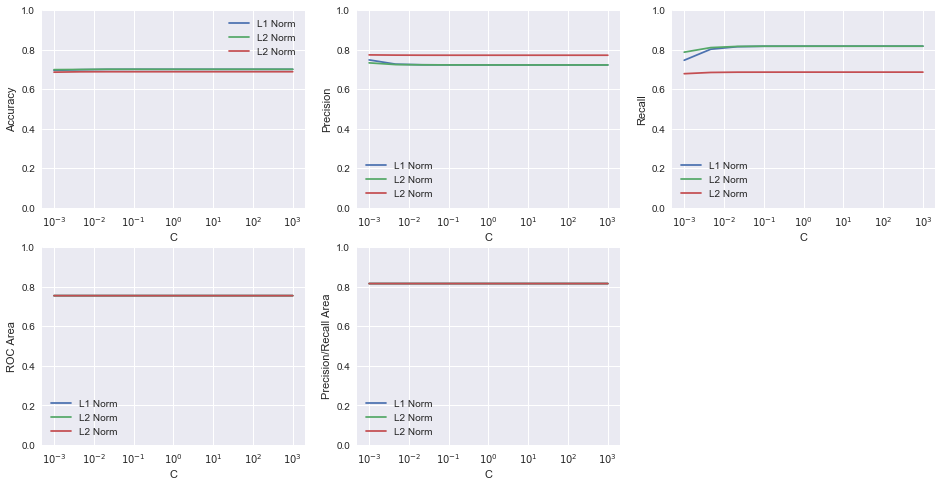

In [40]:
l1 = []
l2 = []
l3 = []
Cvec = np.logspace(start=-3, stop=3, num=10)

# Make transformer that selects the desired attributes from the DataFrame
selector = FunctionTransformer(partial(select_columns, names=['SRS']))

for C in Cvec:
    # Make a pipeline that selects the desired attributes prior to the classifier
    model = make_pipeline(selector, LogisticRegression(penalty='l1', C=C))
    l1 += [evaluate_model(model, X_train, y_train, scoring=scoring)]
    
    model = make_pipeline(selector, LogisticRegression(penalty='l2', C=C))
    l2 += [evaluate_model(model, X_train, y_train, scoring=scoring)]
    
    model = make_pipeline(selector, LogisticRegression(penalty='l2', C=C, class_weight='balanced'))
    l3 += [evaluate_model(model, X_train, y_train, scoring=scoring)]

plot_metrics(Cvec, [l1, l2, l3], 2, 3, ['L1 Norm', 'L2 Norm', 'L2 Norm'], 'C', ylabel, log=True)

# Support Vector Machine

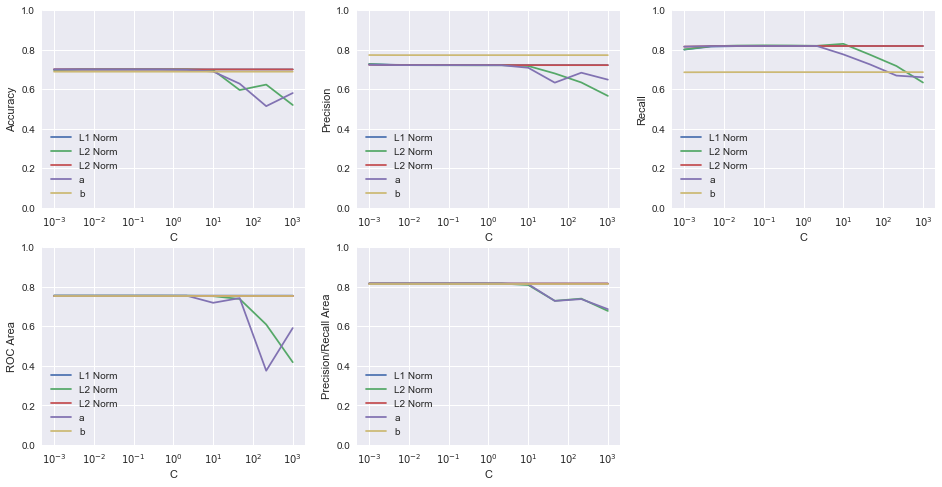

In [28]:
l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
Cvec = np.logspace(start=-3, stop=3, num=10)

# Make transformer that selects the desired attributes from the DataFrame
selector = FunctionTransformer(partial(select_columns, names=['SRS']))

for C in Cvec:
    # Make a pipeline that selects the desired attributes prior to the classifier
    model = make_pipeline(selector, LinearSVC(penalty='l1', loss='squared_hinge', dual=False, C=C))
    l1 += [evaluate_model(model, X_train, y_train, scoring=scoring)]
    
    model = make_pipeline(selector, LinearSVC(penalty='l2', loss='hinge', dual=True, C=C))
    l2 += [evaluate_model(model, X_train, y_train, scoring=scoring)]
    
    model = make_pipeline(selector, LinearSVC(penalty='l2', loss='squared_hinge', dual=False, C=C))
    l3 += [evaluate_model(model, X_train, y_train, scoring=scoring)]
    
    model = make_pipeline(selector, LinearSVC(penalty='l2', loss='squared_hinge', dual=True, C=C))
    l4 += [evaluate_model(model, X_train, y_train, scoring=scoring)]
    
    model = make_pipeline(selector, LinearSVC(penalty='l2', loss='squared_hinge', dual=False, C=C, class_weight='balanced'))
    l5 += [evaluate_model(model, X_train, y_train, scoring=scoring)]

plot_metrics(Cvec, [l1, l2, l3, l4, l5], 2, 3, ['L1 Norm', 'L2 Norm', 'L2 Norm', 'a', 'b'], 'C', ylabel, log=True)

# Random Forest

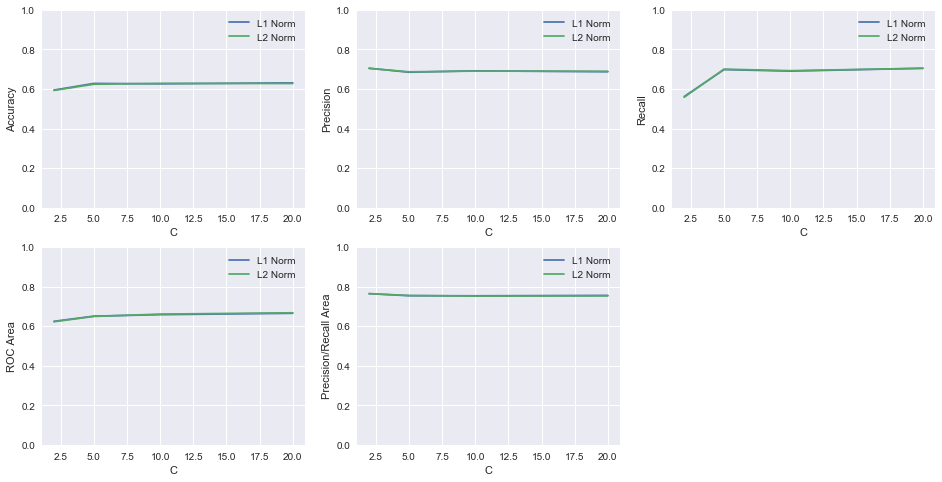

In [32]:
l1 = []
l2 = []
# Make transformer that selects the desired attributes from the DataFrame
selector = FunctionTransformer(partial(select_columns, names=['SRS']))
nVec = [2, 5, 10, 20]

for n in nVec:
    # Make a pipeline that selects the desired attributes prior to the classifier
    model = make_pipeline(selector, RandomForestClassifier(n_estimators=n))
    l1 += [evaluate_model(model, X_train, y_train, scoring=scoring)]
    model = make_pipeline(selector, RandomForestClassifier(n_estimators=n, criterion='entropy'))
    l2 += [evaluate_model(model, X_train, y_train, scoring=scoring)]

plot_metrics(nVec, [l1, l2], 2, 3, ['L1 Norm', 'L2 Norm', 'L2 Norm'], 'C', ylabel)

# Neural Network

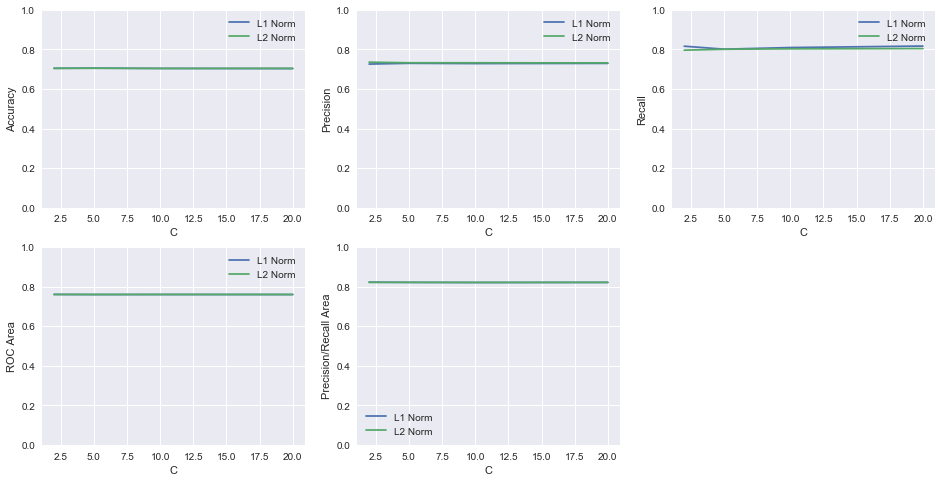

In [33]:
l1 = []
l2 = []
# Make transformer that selects the desired attributes from the DataFrame
selector = FunctionTransformer(partial(select_columns, names=['SRS']))
nVec = [2, 5, 10, 20]

for n in nVec:
    # Make a pipeline that selects the desired attributes prior to the classifier
    model = make_pipeline(selector, MLPClassifier(hidden_layer_sizes=n))
    l1 += [evaluate_model(model, X_train, y_train, scoring=scoring)]
    model = make_pipeline(selector, MLPClassifier(hidden_layer_sizes=n, activation='logistic'))
    l2 += [evaluate_model(model, X_train, y_train, scoring=scoring)]

plot_metrics(nVec, [l1, l2], 2, 3, ['L1 Norm', 'L2 Norm', 'L2 Norm'], 'C', ylabel)